### Importing necessary Libraries

In [1]:
import pandas as pd
import spacy
from tqdm import tqdm
import numpy as np
from sklearn.cluster import AgglomerativeClustering 
from sklearn.metrics.pairwise import pairwise_distances
import matplotlib.pyplot as plt
from fuzzywuzzy import fuzz 
import warnings

warnings.filterwarnings("ignore", message="warning message")

/Users/saikrishnas/miniconda3/lib/python3.10/site-packages/fuzzywuzzy/fuzz.py:11: UserWarning: Using slow pure-python SequenceMatcher. Install python-Levenshtein to remove this warning
  warnings.warn('Using slow pure-python SequenceMatcher. Install python-Levenshtein to remove this warning')


### Import Dataset

In [2]:
# Load the dataset
df = pd.read_excel('Online Retail.xlsx')

### Data Analysis

In [3]:
df.isnull().value_counts()

InvoiceNo  StockCode  Description  Quantity  InvoiceDate  UnitPrice  CustomerID  Country
False      False      False        False     False        False      False       False      406829
                                                                     True        False      133626
                      True         False     False        False      True        False        1454
dtype: int64

In [4]:
# Removing null values
df.dropna(inplace=True)
df.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850.0,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom


In [5]:
df.shape

(406829, 8)

In [6]:
df.columns

Index(['InvoiceNo', 'StockCode', 'Description', 'Quantity', 'InvoiceDate',
       'UnitPrice', 'CustomerID', 'Country'],
      dtype='object')

In [7]:
df['Country'].value_counts()

United Kingdom          361878
Germany                   9495
France                    8491
EIRE                      7485
Spain                     2533
Netherlands               2371
Belgium                   2069
Switzerland               1877
Portugal                  1480
Australia                 1259
Norway                    1086
Italy                      803
Channel Islands            758
Finland                    695
Cyprus                     622
Sweden                     462
Austria                    401
Denmark                    389
Japan                      358
Poland                     341
USA                        291
Israel                     250
Unspecified                244
Singapore                  229
Iceland                    182
Canada                     151
Greece                     146
Malta                      127
United Arab Emirates        68
European Community          61
RSA                         58
Lebanon                     45
Lithuani

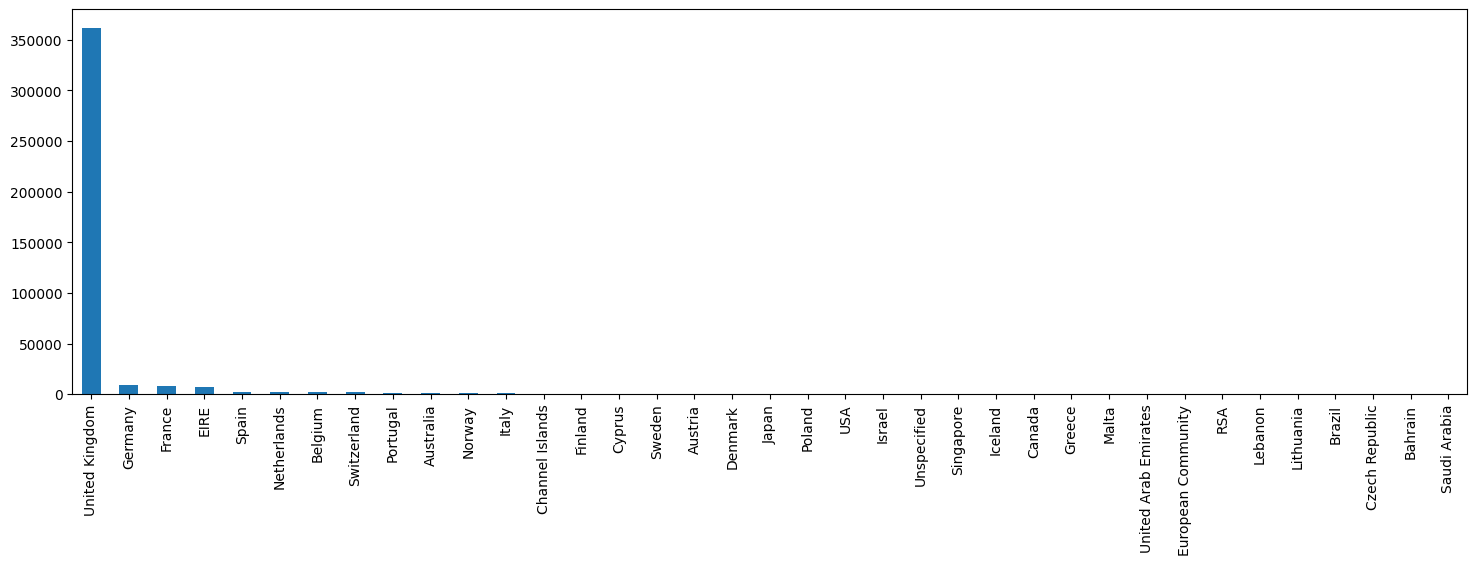

In [8]:
df['Country'].value_counts().plot.bar(figsize=(18,5))
plt.show()

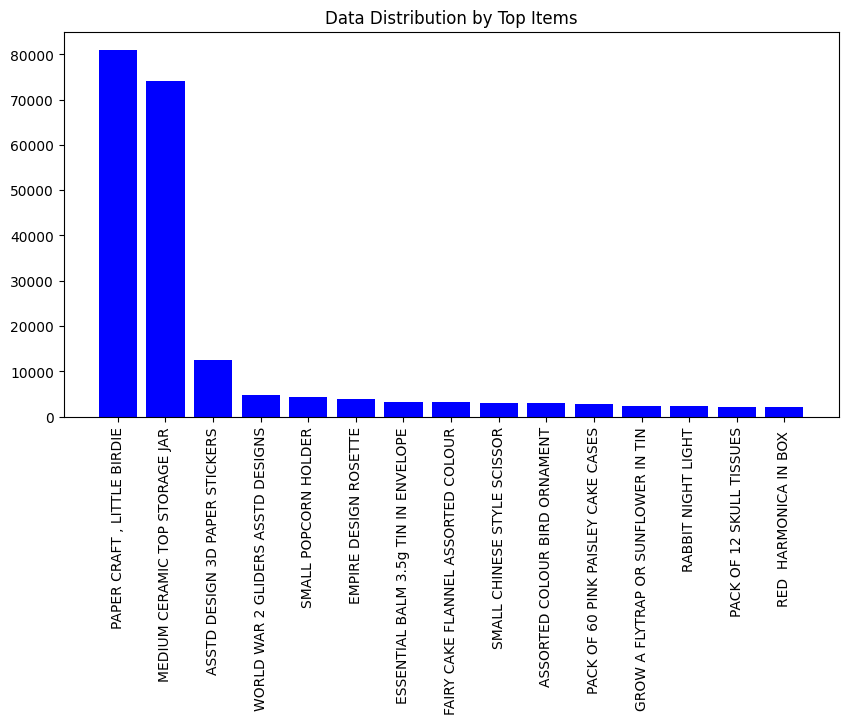

In [9]:
sorted_df = df.sort_values(by=['Quantity'], ascending=False)
top_items = sorted_df[:3]
fig = plt.figure(figsize=(10, 5))
x = sorted_df['Description'][:20]
y = sorted_df['Quantity'][:20]
plt.bar(x, y, color='blue')
plt.xticks(rotation = 90)
plt.title('Data Distribution by Top Items')
plt.show()

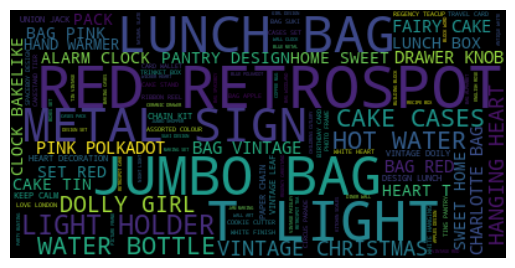

In [10]:
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator

retail_purchases = df['Description']
descriptions = retail_purchases.str.cat(sep=' ')

# Start with one review:
text = descriptions

# Create and generate a word cloud image:
wordcloud = WordCloud().generate(text)

# Display the generated image:
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()


### Data Preprocessing

In [11]:
# Import necessary libraries
nlp = spacy.load('en_core_web_sm')

# Method to extract nouns and proper nouns from a string
def extract_nouns(text):
    doc = nlp(text)
    nouns = []
    for token in doc:
        if token.pos_ in ['NOUN', 'PROPN']:
            nouns.append(token.text)
    return nouns


In [12]:
# To get the unique values of the 'Description'
unique_desc_df = df['Description'].unique()

# To create a dictionary to map each unique value to its extracted nouns
desc_nouns_dict = {}
for desc in tqdm(unique_desc_df, desc='Extracting nouns', total=len(unique_desc_df)):
    desc_nouns_dict[desc] = extract_nouns(desc)

# To map the extracted nouns back to each row in the 'Description' in DataFrame
tqdm.pandas(desc='Mapping nouns')
df['nouns'] = df['Description'].progress_map(lambda desc: desc_nouns_dict[desc])


Mapping nouns: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 406829/406829 [00:00<00:00, 1829852.07it/s]


In [13]:
df['nouns'] = df['nouns'].apply(lambda x: " ".join(x)) 
df.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,nouns
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850.0,United Kingdom,WHITE HANGING HEART T LIGHT HOLDER
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,WHITE METAL LANTERN
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850.0,United Kingdom,CREAM CUPID HEARTS COAT HANGER
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,KNITTED UNION FLAG HOT WATER BOTTLE
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,RED WOOLLY HOTTIE WHITE HEART


In [14]:
df['nouns'].unique()

array(['WHITE HANGING HEART T LIGHT HOLDER', 'WHITE METAL LANTERN',
       'CREAM CUPID HEARTS COAT HANGER', ...,
       'PINK CRYSTAL SKULL PHONE CHARM', 'CREAM HEART T LIGHT HOLDER',
       'PAPER CRAFT LITTLE BIRDIE'], dtype=object)

In [15]:
# Method to generate a category name based on the most common words in the item
def create_category_name(items):
    # Combine the item descriptions into a single string
    item_text = " ".join(items)
    # Parse the text using spaCy
    doc = nlp(item_text)
    # Create a dictionary to store the frequency of each word
    word_freq = {} 
    for token in doc:
        if token.is_alpha and not token.is_stop and len(token.text) > 2: 
            if token.text.lower() in word_freq:
                word_freq[token.text.lower()] += 1 
            else:
                word_freq[token.text.lower()] = 1
    # Sort the words by frequency and take the top 3
    top_words = sorted(word_freq, key=word_freq.get, reverse=True)[:3] 
    # Combine the top words into a category name
    category_name = " ".join(top_words)
    return category_name

# Method to calculate the similarity using levenshtein similarity
def levenshtein_similarity(s1, s2):
    return fuzz.ratio(s1.lower(), s2.lower())

In [16]:
thresh = 55
# Extract unique items from the dataset
unique_items = df['nouns'].unique()
# Create a dictionary to store the item categories
item_categories = {}
# Iterate over each item in the dataset and assign it to a category based on its similarity to existing items
for item in tqdm(unique_items, total=unique_items.shape[0], desc="Finding item categories"):
    item_description = item
    category_found = False
    for category, items in item_categories.items():
        for existing_item in items:
            if levenshtein_similarity(item_description, existing_item) > thresh:
                item_categories[category].append(item_description)
                category_found = True
                break
        if category_found:
            break
    if not category_found:
        item_categories[item_description] = [item_description]


Finding item categories: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 3740/3740 [01:13<00:00, 50.65it/s]


In [17]:
# Create a dictionary to store the category names
category_names = {}

# Iterate over each category and generate a name for it
for category, items in tqdm(item_categories.items(), desc="Creating category names"):
    category_names[category] = create_category_name(items)

len(category_names), list(category_names.values())[:20]


Creating category names: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 343/343 [00:05<00:00, 67.40it/s]


(343,
 ['pink heart set',
  'metal white blue',
  'hanger cream cupid',
  'set retrospot bottle',
  'white antique heart',
  'babushka pink set',
  'red vintage hand',
  'assorted colour suction',
  'poppy playhouse kitchen',
  'feltcraft doll cushion',
  'ivory knitted mug',
  'colour lily brooch',
  'vintage seaside box',
  'building block word',
  'metal sign hook',
  'new england',
  'jam set jar',
  'coat rack paris',
  'alarm clock bakelike',
  'sticker sheet folk'])

In [18]:
# Map the categories to the original dataframe
df['Category'] = ""
for index, row in tqdm(df.iterrows(), total=len(df), desc="Mapping categories"):
    item_description = row['nouns']
    for category, items in item_categories.items():
        if item_description in items:
            df.at[index, 'Category'] = category_names[category]
            break


Mapping categories: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 406829/406829 [00:28<00:00, 14182.36it/s]


In [19]:
df.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,nouns,Category
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850.0,United Kingdom,WHITE HANGING HEART T LIGHT HOLDER,pink heart set
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,WHITE METAL LANTERN,metal white blue
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850.0,United Kingdom,CREAM CUPID HEARTS COAT HANGER,hanger cream cupid
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,KNITTED UNION FLAG HOT WATER BOTTLE,set retrospot bottle
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,RED WOOLLY HOTTIE WHITE HEART,white antique heart


In [20]:
# Helper functions

# Method to get customer invoices
def get_cust_invoices(custID=17850.0):
    return list(set(df[df['CustomerID'] == custID]['InvoiceNo']))

# Method to get invoice items
def get_invoice_items(invoiceID = 536365, get='Description'):
    return list(set(df[df['InvoiceNo'] == invoiceID][get]))

# Method to get items
def get_df_items(columnname="CustomerID", columnID = 17850.0):
    return df[df[columnname] == columnID]

In [21]:
list(get_df_items(columnname="Category", columnID="assorted colour set")["Description"])[:20]

[]

In [22]:
# To get the invoice items for the first invoice
basket = get_invoice_items(df["InvoiceNo"][0], get='nouns')

# To generate a category name for the basket
basket_category = create_category_name(basket)

# Print the most similar category to the basket
print(f"The most similar category to the basket: \n{basket}\n is {basket_category}")


The most similar category to the basket: 
['KNITTED UNION FLAG HOT WATER BOTTLE', 'RED WOOLLY HOTTIE WHITE HEART', 'WHITE HANGING HEART T LIGHT HOLDER', 'CREAM CUPID HEARTS COAT HANGER', 'GLASS STAR FROSTED T LIGHT HOLDER', 'WHITE METAL LANTERN', 'SET BABUSHKA NESTING BOXES']
 is white heart light


In [23]:
from fuzzywuzzy import process 

# Find the closest match in the list using process from fuzzy
closest_match = process.extractOne(basket_category, df["Category"].unique(),scorer=fuzz.token_sort_ratio)

# Print the closest match
print(closest_match)

('white felt farm', 69)


In [24]:
get_df_items(columnname="Category", columnID=closest_match[0]).sort_values(by=["Quantity"], ascending=False).head(10)


,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,nouns,Category
16440,537659,82484,WOOD BLACK BOARD ANT WHITE FINISH,600,2010-12-07 16:43:00,4.78,18102.0,United Kingdom,WOOD BLACK BOARD ANT WHITE FINISH,white felt farm
16425,537657,82484,WOOD BLACK BOARD ANT WHITE FINISH,408,2010-12-07 16:42:00,4.78,18102.0,United Kingdom,WOOD BLACK BOARD ANT WHITE FINISH,white felt farm
323344,565291,82482,WOODEN PICTURE FRAME WHITE FINISH,324,2011-09-02 11:53:00,1.92,18102.0,United Kingdom,PICTURE FRAME WHITE FINISH,white felt farm
323343,565291,82484,WOOD BLACK BOARD ANT WHITE FINISH,300,2011-09-02 11:53:00,4.80,18102.0,United Kingdom,WOOD BLACK BOARD ANT WHITE FINISH,white felt farm
133989,547812,82484,WOOD BLACK BOARD ANT WHITE FINISH,300,2011-03-25 14:06:00,4.77,18102.0,United Kingdom,WOOD BLACK BOARD ANT WHITE FINISH,white felt farm
31497,538991,22264,FELT FARM ANIMAL WHITE BUNNY,288,2010-12-15 11:53:00,0.19,17511.0,United Kingdom,FELT FARM ANIMAL WHITE BUNNY,white felt farm
282707,561655,82482,WOODEN PICTURE FRAME WHITE FINISH,216,2011-07-28 16:00:00,1.92,18102.0,United Kingdom,PICTURE FRAME WHITE FINISH,white felt farm
439053,574352,82482,WOODEN PICTURE FRAME WHITE FINISH,216,2011-11-04 10:38:00,1.92,18102.0,United Kingdom,PICTURE FRAME WHITE FINISH,white felt farm
225613,556726,22171,3 HOOK PHOTO SHELF ANTIQUE WHITE,204,2011-06-14 11:31:00,5.88,18102.0,United Kingdom,HOOK PHOTO SHELF ANTIQUE WHITE,white felt farm
225607,556726,82484,WOOD BLACK BOARD ANT WHITE FINISH,204,2011-06-14 11:31:00,4.80,18102.0,United Kingdom,WOOD BLACK BOARD ANT WHITE FINISH,white felt farm


In [25]:
np.random.choice(get_df_items(columnname="Category", columnID=closest_match[0]).sort_values('Quantity', ascending=False)['nouns'].unique(), size=5, replace=False)


array(['WOOD DRAWER CABINET WHITE FINISH',
       'WOOD BLACK BOARD ANT WHITE FINISH', 'FELT FARM ANIMAL SHEEP',
       'FELT FARM ANIMAL RABBIT', 'FELT FARM ANIMAL HEN'], dtype=object)

In [26]:
invoice_no = 536368

# Given invoice number, get all items in that invoice
basket = get_invoice_items(invoice_no, get='nouns')

# Bin the basket into a category
basket_category = create_category_name(basket)

# Find the most similar category
matches = process.extract(basket_category, df["Category"].unique(), scorer=fuzz.token_sort_ratio)
matches_sorted = sorted(matches, key=lambda x: x[1], reverse=True)

for closest_match, _ in matches_sorted:
    # Get the items of the closest category and sort them by quantity
    similar_items = get_df_items(columnname="Category", columnID=closest_match).sort_values(by="Quantity", ascending=False)

    # Remove the items already in the basket
    similar_items = similar_items[~similar_items["nouns"].isin(basket)]

    if len(similar_items) > 0:
        break

# Get a random item from the top 3 items
recommendation = np.random.choice(similar_items["nouns"].unique()[:3])
print(f"Recommended item: {recommendation}")


Recommended item: GUMBALL MONOCHROME COAT RACK


### Modelling

In [27]:
# Method to get the recommendations based on invoice number
def get_recommendation(invoice_no):
    # given invoice number get all items in that invoice
    basket = get_invoice_items(invoice_no, get='nouns')
    basket = [" ".join(extract_nouns(text)) for text in basket]
    
    # bin the basket into a category
    basket_category = create_category_name(basket)
    
    # find the most similar category
    matches = process.extract(basket_category, df["Category"].unique(), scorer=fuzz.token_sort_ratio)
    matches_sorted = sorted(matches, key=lambda x: x[1], reverse=True)

    for closest_match, _ in matches_sorted:
        # get the items of the closest category and sort them by Quantity
        similar_items = get_df_items(columnname="Category", columnID=closest_match).sort_values(by='Quantity', ascending=False)

        # remove the items already in the basket
        similar_items = similar_items[~similar_items['Description'].isin(basket)]

        if len(similar_items) > 0:
            recommendation = np.random.choice(similar_items['Description'].unique()[:3])
            return recommendation
    
    return "No recommendation found."

# Method to get the recommendations from basket
def get_basket_rec(basket):
    # bin the basket into a category
    basket_category = create_category_name(basket)
    
    # To find the most similar category
    matches = process.extract(basket_category, df["Category"].unique(), scorer=fuzz.token_sort_ratio)
    matches_sorted = sorted(matches, key=lambda x: x[1], reverse=True)

    for closest_match, _ in matches_sorted:
        # To get the items of the closest category and sort them by Quantity
        similar_items = get_df_items(columnname="Category", columnID=closest_match).sort_values(by='Quantity', ascending=False)

        # To remove the items already in the basket
        similar_items = similar_items[~similar_items['Description'].isin(basket)]

        if len(similar_items) > 0:
            recommendation = np.random.choice(similar_items['Description'].unique()[:3])
            return recommendation
    
    return "No recommendation found."

get_recommendation(562439)


'HAPPY STENCIL CRAFT'

In [28]:
get_basket_rec(["Milk", "eggs", "bread", "banana"])

'EGG CUP MILKMAID INGRID'

In [29]:
get_basket_rec(["toothpaste", "brush", "mouthwash", "soap"])

'TOAST ITS - BEST MUM'

In [30]:
# Get unique Invoice Number values
unique_invoices = df['InvoiceNo'].unique()

# Initialize a list to store the recommendations for each unique invoice
unique_recommendations = []

# Loop through each unique invoice and apply the get_recommendation function
for invoice in tqdm(unique_invoices): 
    recommendation = get_recommendation(invoice) 
    unique_recommendations.append(recommendation)

# Map the recommendations back to the DataFrame
df['Recommendation'] = df['InvoiceNo'].map(dict(zip(unique_invoices, unique_recommendations)))


 37%|██████████████████████████████████████████████████████████████▏                                                                                                       | 8305/22190 [21:33<27:58,  8.27it/s]WARNING:root:Applied processor reduces input query to empty string, all comparisons will have score 0. [Query: '']


 63%|████████████████████████████████████████████████████████████████████████████████████████████████████████                                                             | 13993/22190 [37:05<25:56,  5.27it/s]WARNING:root:Applied processor reduces input query to empty string, all comparisons will have score 0. [Query: '']


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 22190/22190 [1:01:38<00:00,  6.00it/s]


In [38]:
df['Recommendation']

0         FELT FARM ANIMAL WHITE BUNNY 
1         FELT FARM ANIMAL WHITE BUNNY 
2         FELT FARM ANIMAL WHITE BUNNY 
3         FELT FARM ANIMAL WHITE BUNNY 
4         FELT FARM ANIMAL WHITE BUNNY 
                      ...              
541904             INCENSE BAZAAR PEACH
541905             INCENSE BAZAAR PEACH
541906             INCENSE BAZAAR PEACH
541907             INCENSE BAZAAR PEACH
541908             INCENSE BAZAAR PEACH
Name: Recommendation, Length: 406829, dtype: object

In [39]:
unique_df = df.drop_duplicates(subset=["InvoiceNo"])
unique_df[["InvoiceNo", "Recommendation"]].to_csv('recommendations.csv', index=False)


In [40]:
# To create an empty DataFrame with the custom column names
summary_table = pd.DataFrame(columns=['Description', 'Invoice Count', 'Recommendation Count'])

# To iterate over the unique recommended items and add them to the summary table
unique_recs = df["Recommendation"].unique()
for item in tqdm(unique_recs):
    invoice_count = df[df['Description'] == item]['InvoiceNo'].nunique()
    recommendation_count = unique_df[unique_df['Recommendation'] == item]['InvoiceNo'].count()
    summary_table = pd.concat([summary_table, pd.DataFrame([[item, invoice_count, recommendation_count]], columns=['Description', 'Invoice Count', 'Recommendation Count'])])

# Exporting Summary Table to CSV
summary_table.to_csv('summary_table.csv', index = False)


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 620/620 [00:11<00:00, 56.33it/s]


In [41]:
summary_table

,Description,Invoice Count,Recommendation Count
0,FELT FARM ANIMAL WHITE BUNNY,40,60
0,HAND OPEN SHAPE GOLD,24,26
0,BEACH HUT DESIGN BLACKBOARD,10,26
0,GUMBALL MONOCHROME COAT RACK,38,39
0,BEACH HUT MIRROR,8,21
...,...,...,...
0,WRAP FOLK ART,8,1
0,LITTLE GREEN MONSTER SOFT TOY,9,1
0,CHRYSANTHEMUM POCKET BOOK,20,1
0,MIRRORED WALL ART GENTS,35,1


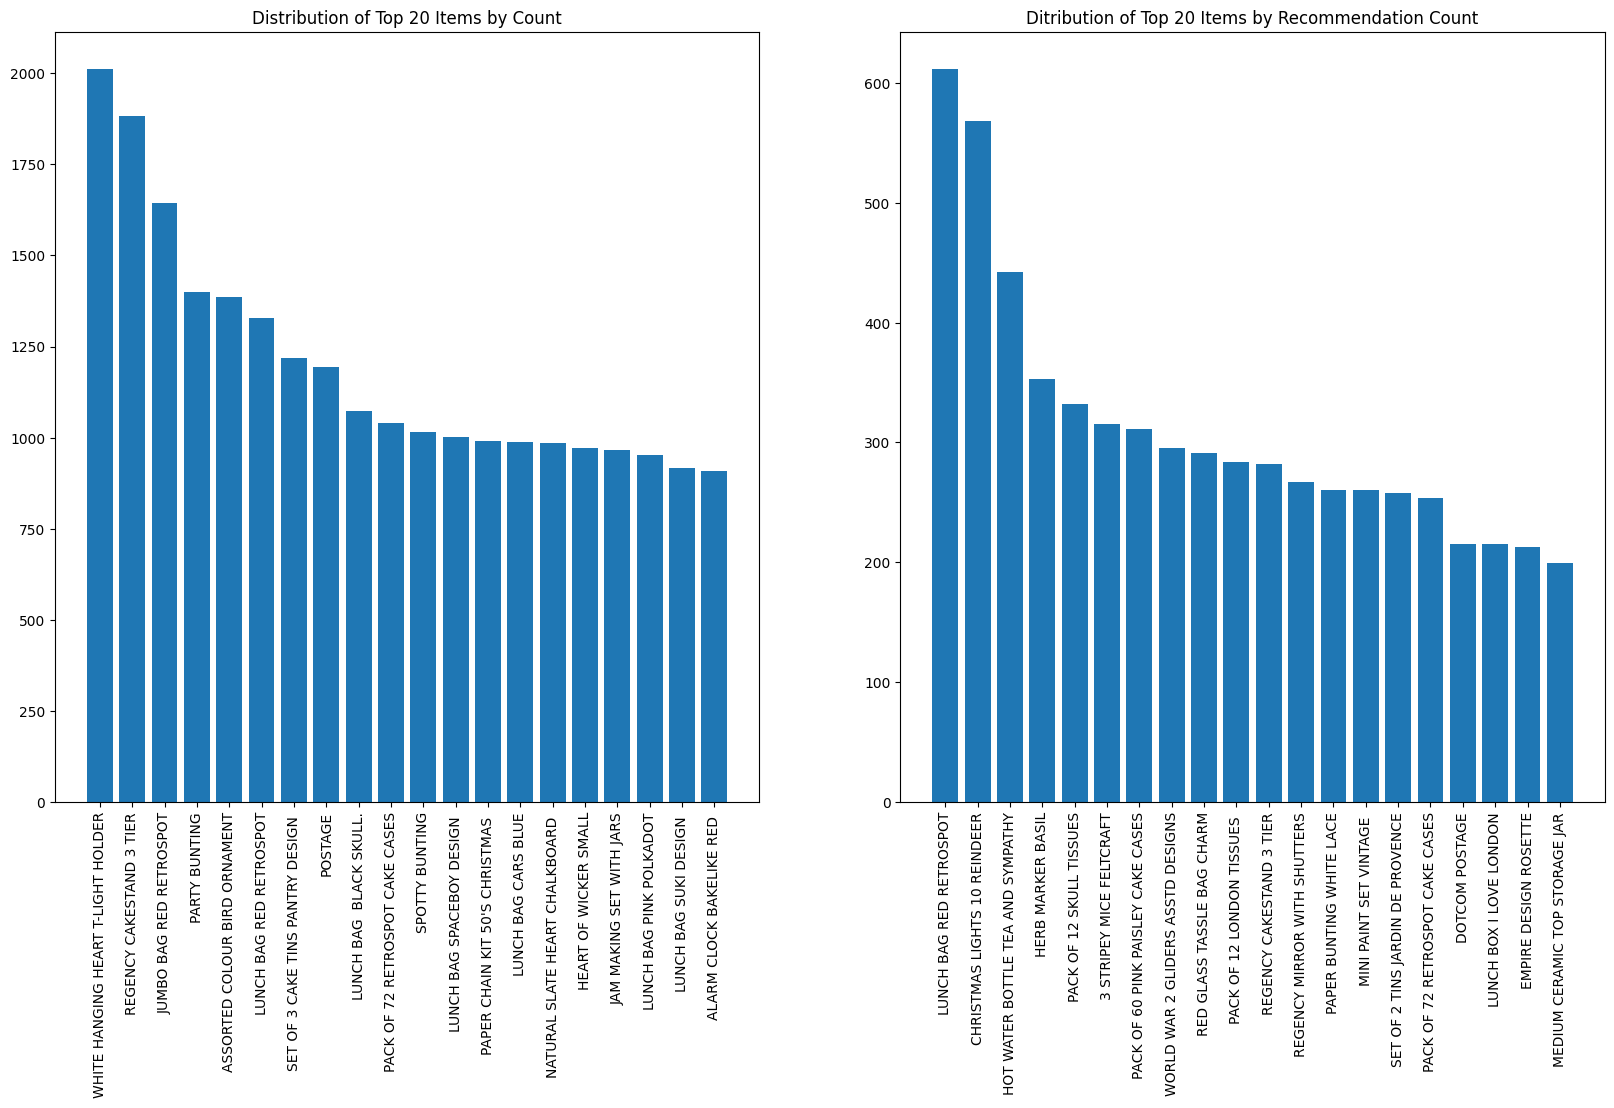

In [42]:
summary_table = df.groupby(['Description', 'InvoiceNo']).size().reset_index(name='Count')
invoice_counts = summary_table.groupby('Description')['InvoiceNo'].nunique().reset_index(name='Invoice Count')
recommendation_counts = df.groupby('Recommendation')['InvoiceNo'].nunique().reset_index(name='Recommendation Count')
summary = pd.merge(invoice_counts, recommendation_counts, left_on='Description', right_on='Recommendation', how='outer')
inv_sort = summary.sort_values(by='Invoice Count', ascending=False)[:20]
rec_sort = summary.sort_values(by='Recommendation Count', ascending=False)[:20]

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 10))
ax1.bar(inv_sort['Description'], inv_sort['Invoice Count'])
ax1.set_title('Distribution of Top 20 Items by Count')
ax1.tick_params(axis='x', rotation=90)
ax2.bar(rec_sort['Recommendation'], rec_sort['Recommendation Count'])
ax2.set_title('Ditribution of Top 20 Items by Recommendation Count')
ax2.tick_params(axis='x', rotation=90)
plt.show()
